# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.emfiles import crop_fourier_images, crop_fourier_volume
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import conjugate_gradient, get_cg_vol_ops
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

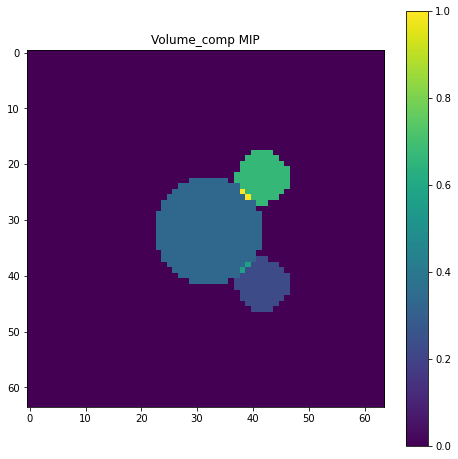

In [3]:
nx = 64
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0]])
radii = np.array([3, 1.5, 1.5])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

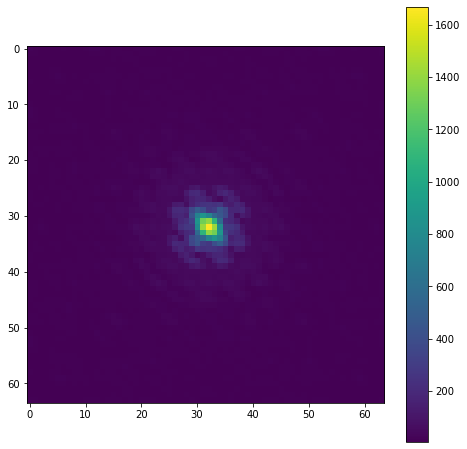

In [4]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [5]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


Generate projections (in Fourier domain)

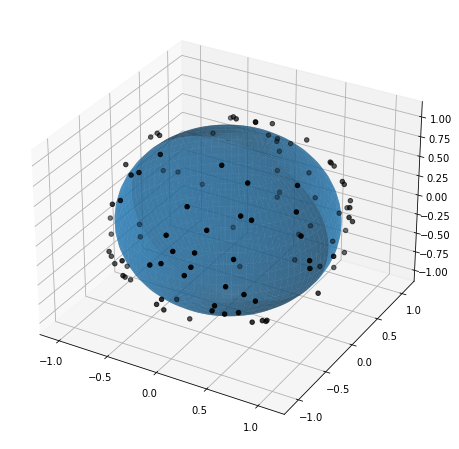

In [6]:
# Orientations
N = 100

#s = 0.05
s = 0.1
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

In [7]:
angles_true.shape

(100, 3)

1.531736135482788
0.14815510811489782


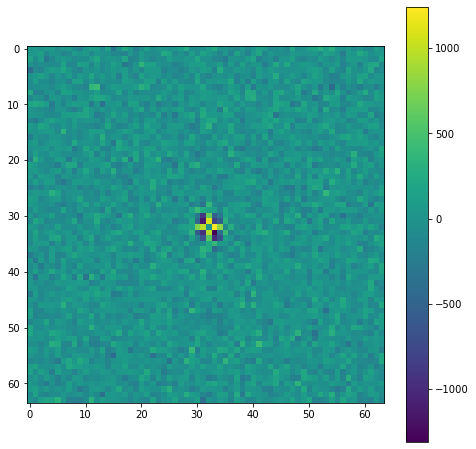

In [8]:
radius = 10
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

norm0 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

norm1 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

print(time.time()-start)

#SNR
print(norm0/norm1)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [9]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

0.3120310306549072


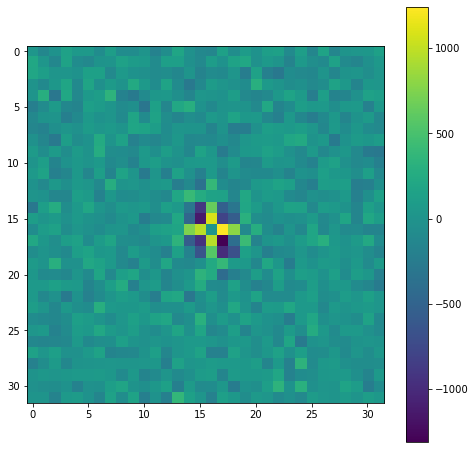

In [10]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

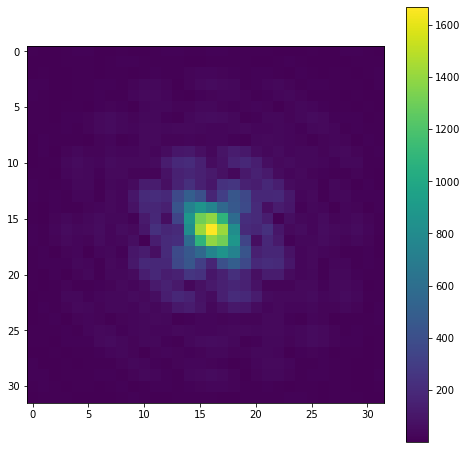

In [11]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

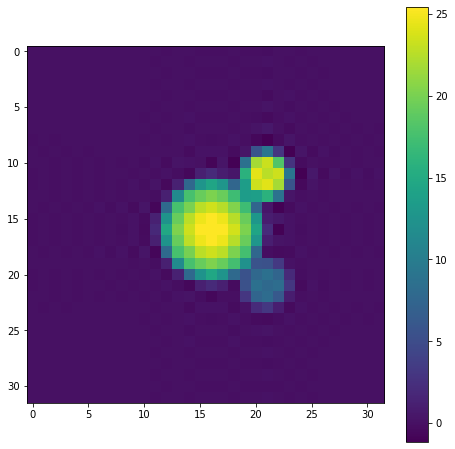

In [12]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

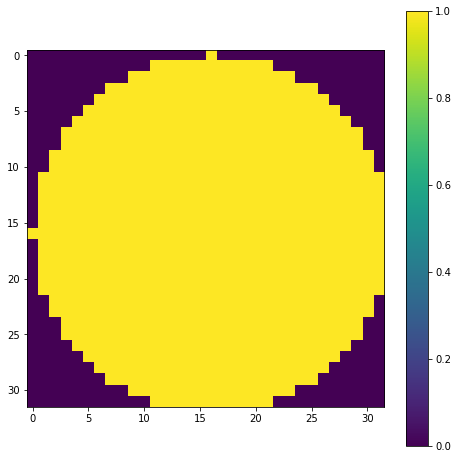

In [13]:
alpha = 0.01

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [14]:
start = time.time()
ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

1.4730761051177979
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [15]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.6598467826843262
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

2.378997325897217
(32, 32, 32)


### Orientations

In [17]:
# Here, we generate new random orientations for each image, no storing of projections.

loss_func_angles = jax.jit(jax.vmap(loss_func, in_axes = (None, 0, None, None, None)))

def sample_new_angles_one_img(loss_func_angles, vol, shifts_true, ctf_params, img, N_samples):
    ang_samples = generate_uniform_orientations(N_samples)
    loss = loss_func_angles(vol, ang_samples, shifts_true, ctf_params, img)
    li = jnp.argmin(loss)
    return ang_samples[li]

def sample_new_angles(loss_func_angles, vol, shifts_true, ctf_params, imgs, N_samples):
    angles = []
    for ai in range(N):
        ang_samples = generate_uniform_orientations(N_samples)
        loss = loss_func_angles(vol, ang_samples, shifts_true[ai], ctf_params[ai], imgs[ai])
        li = jnp.argmin(loss)
        angles.append(ang_samples[li])
    return jnp.array(angles) 

sample_new_angles_vmap = jax.vmap(sample_new_angles_one_img, in_axes = (None, None, 0, 0, 0, None))

In [18]:
# Alternative approach where we generate the same N_samples orientations, store the projected
# images and compare each data image with the projections. Should be faster.

def loss_func_imgs_batched(img0, imgs):
    """Compute the loss between img0 and each image in the imgs array."""
    return jax.vmap(l2sq, in_axes = (None, 0))(img0, imgs)


def get_min_loss_index(img0, imgs, loss_func_array):
    """Given img0 and the array imgs, return the index in imgs of the image
    with the lowest loss with img0."""
    
    loss = loss_func_array(img0, imgs) 
    return jnp.argmin(loss)

def get_min_loss_indices(imgs1, imgs2, loss_func_array):
    return jax.vmap(get_min_loss_index, in_axes=(0, None, None))(imgs1, imgs2, loss_func_array)

def sample_new_angles_cached(loss_func_imgs_batched, slice_func_array_angles, vol, shifts_true, ctf_params, imgs, N_samples):
    ang_samples = generate_uniform_orientations(N_samples)
    imgs_sampled = slice_func_array_angles(vol, ang_samples, shifts_true, ctf_params)
    indices = get_min_loss_indices(imgs, imgs_sampled, loss_func_imgs_batched) 
        
    return ang_samples[indices]

In [43]:
N_samples = 10000
N_iter = 10
N_cg_iter = 150
dr = 0.05
#radius = 0.05
radius = 0.15

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
vcg = v0
loss_min = jnp.inf
loss = jnp.inf * jnp.ones(N_samples)
li = 0

Iter 0 ||r|| = 0.33997157467925926
Iter 50 ||r|| = 0.0003296395681921118
Iter 100 ||r|| = 0.0001754542275734418


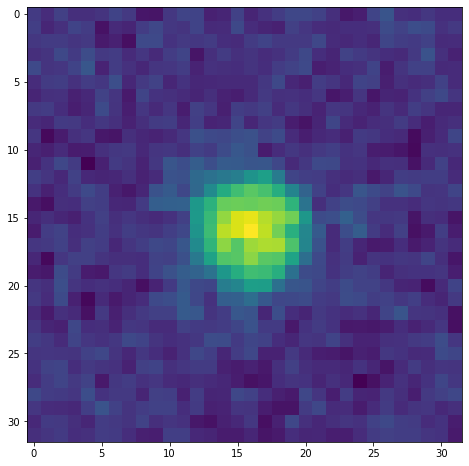

In [44]:
angles = generate_uniform_orientations(N)

AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles, shifts_true, ctf_params, imgs, v0.shape)
vcg, _ = conjugate_gradient(AA, Ab, v0, N_cg_iter, verbose=True)
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:]))))

Iter  0
time angles = 15.870661973953247
Iter 0 ||r|| = 0.5310423105218454
Iter 50 ||r|| = 0.00021379868743169177
Iter 100 ||r|| = 0.00011864830902387904
time cg = 4.905642986297607


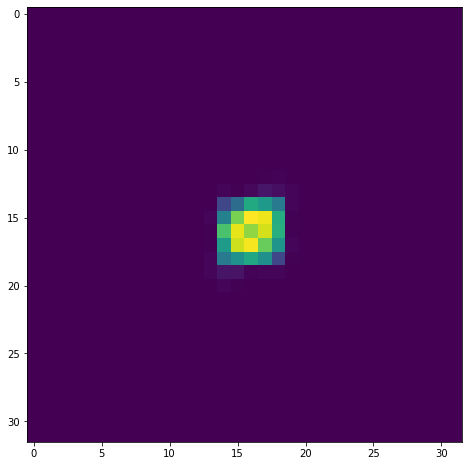

Iter  1
time angles = 11.976140022277832
Iter 0 ||r|| = 0.4024793361885438
Iter 50 ||r|| = 0.00025933493497880413
Iter 100 ||r|| = 0.0001930866780410566
time cg = 4.972728967666626


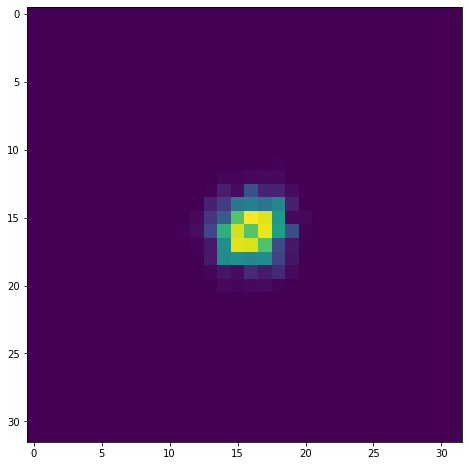

Iter  2
time angles = 11.716309070587158
Iter 0 ||r|| = 0.45257858657316263
Iter 50 ||r|| = 0.0003027628085981915
Iter 100 ||r|| = 0.00017895977698473875
time cg = 4.935660123825073


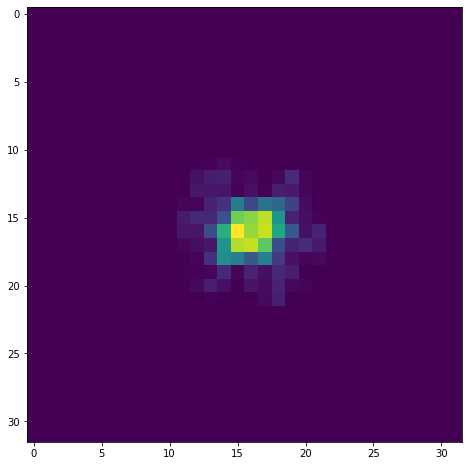

Iter  3
time angles = 11.481631994247437
Iter 0 ||r|| = 0.4108363018715171
Iter 50 ||r|| = 0.0002866805761026631
Iter 100 ||r|| = 0.0002206498448344587
time cg = 4.909042119979858


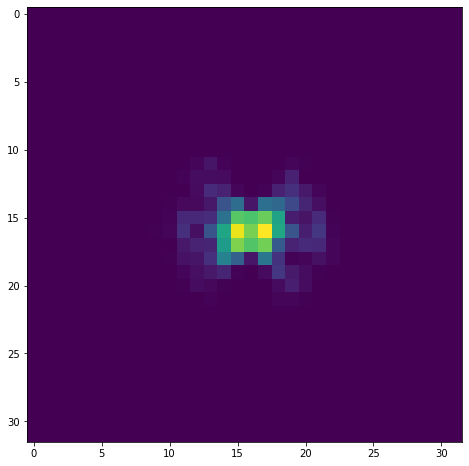

Iter  4
time angles = 12.079200983047485
Iter 0 ||r|| = 0.4000592687635105
Iter 50 ||r|| = 0.0003110764965863821
Iter 100 ||r|| = 0.00019529495157308678
time cg = 4.872003078460693


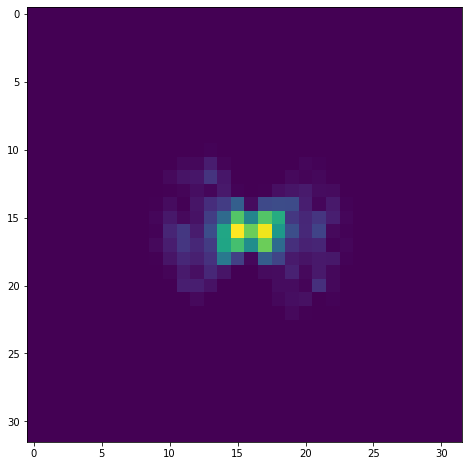

Iter  5
time angles = 13.384290218353271
Iter 0 ||r|| = 0.3939630270781721
Iter 50 ||r|| = 0.00031917787256619494
Iter 100 ||r|| = 0.00021313353542935716
time cg = 5.18461799621582


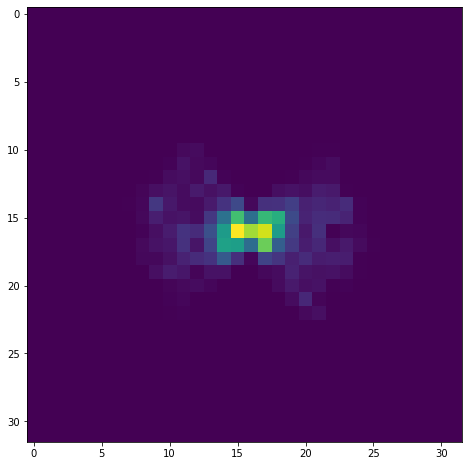

Iter  6
time angles = 13.394026041030884
Iter 0 ||r|| = 0.39985059959582214
Iter 50 ||r|| = 0.0004525948079881314
Iter 100 ||r|| = 0.00027182102116237356
time cg = 4.845226049423218


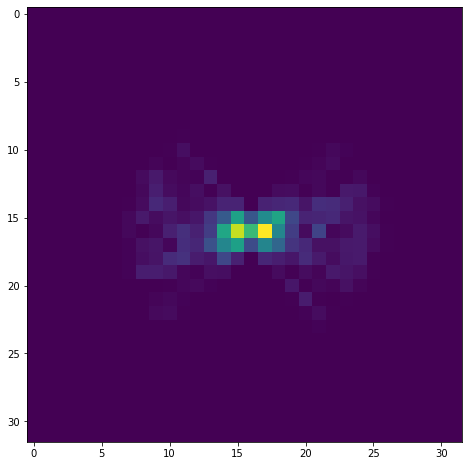

Iter  7
time angles = 13.598278760910034
Iter 0 ||r|| = 0.3996512306596285
Iter 50 ||r|| = 0.0003853371041060492
Iter 100 ||r|| = 0.0002154595769197065
time cg = 4.870926856994629


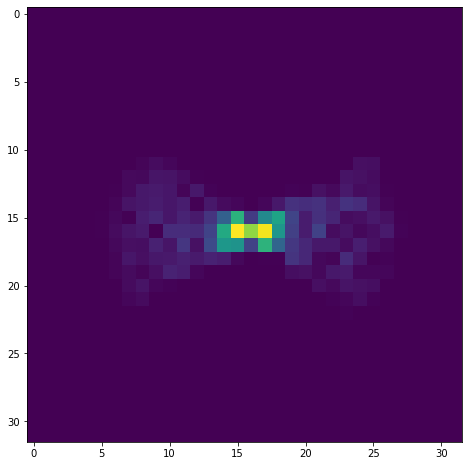

Iter  8
time angles = 14.45101284980774
Iter 0 ||r|| = 0.41120105086273717
Iter 50 ||r|| = 0.00030010305076285564
Iter 100 ||r|| = 0.00020983471410884193
time cg = 4.678116083145142


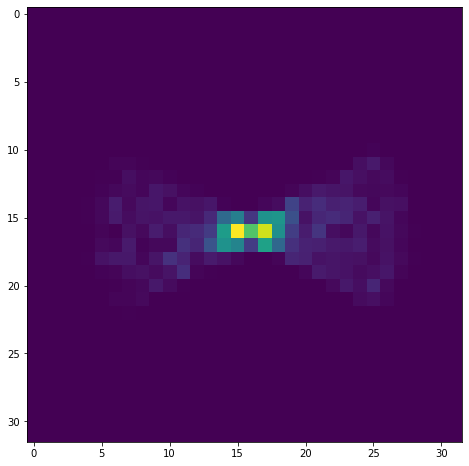

Iter  9
time angles = 14.85431694984436
Iter 0 ||r|| = 0.4160210239149098
Iter 50 ||r|| = 0.00025586777345733806
Iter 100 ||r|| = 0.00020824273796961063
time cg = 5.402201175689697


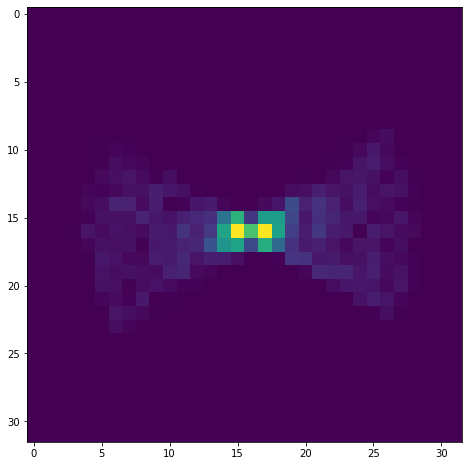

In [45]:
for idx in range(N_iter):
    print("Iter ", idx)
    
    mask3d = create_3d_mask(x_grid, (0,0,0),radius)
    mask2d = mask3d[0].reshape(1,-1)
    
    
    #TODO: make this function return the loss numbers as well so they don't have to be recomputed below
    # 2. Why is CG slower when using the vmapped version? Some recompilation happening? maybe th memory is too full and everything is slow,
    # maybe some garbage collection happening
    # More obvious with 10k samples.
    t0 = time.time()    
    #angles = sample_new_angles_vmap(loss_func_angles, vcg*mask3d, shifts_true, ctf_params, imgs*mask2d, N_samples)    
    angles = sample_new_angles_cached(loss_func_imgs_batched, slice_func_array_angles, vcg*mask3d, shifts_true[0], ctf_params[0], imgs*mask2d, N_samples)    
    print("time angles =", time.time()-t0)

    
    #loss_min = loss_func_sum(vcg*mask3d, angles, shifts_true, ctf_params, imgs)/jnp.sum(mask2d)
    #print("angles loss", loss_min)
    
    #Q: am I applying no masking here? hmmm
    t0 = time.time()
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles, shifts_true, ctf_params, imgs*mask2d, v0.shape)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_cg_iter, verbose=True)
    print("time cg =", time.time()-t0)

    
    radius += dr
    
    #plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[:,:,0])*mask2d.reshape(32,32))))
    #plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[:,:,0]))))
    plt.imshow(jnp.abs(jnp.fft.fftshift(vcg[:,:,0])))
    plt.show()

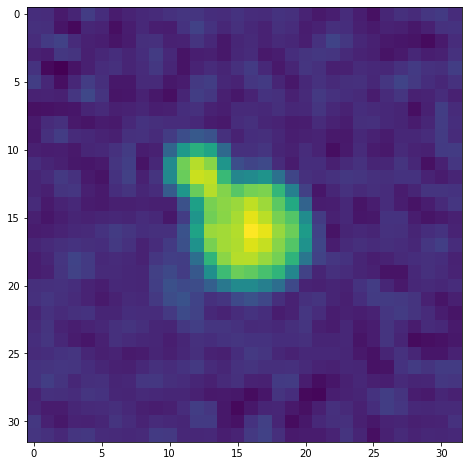

In [46]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:]))))

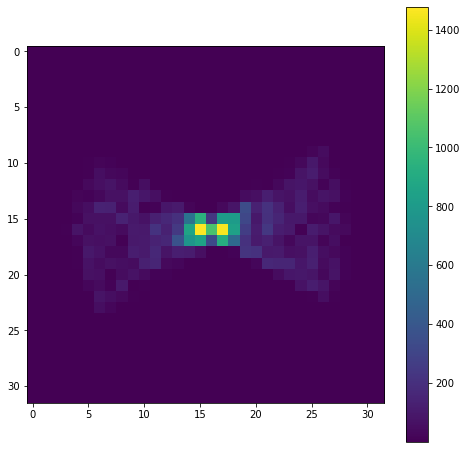

In [47]:
plt.imshow(jnp.abs(jnp.fft.fftshift(vcg[:,:,0]))); plt.colorbar()

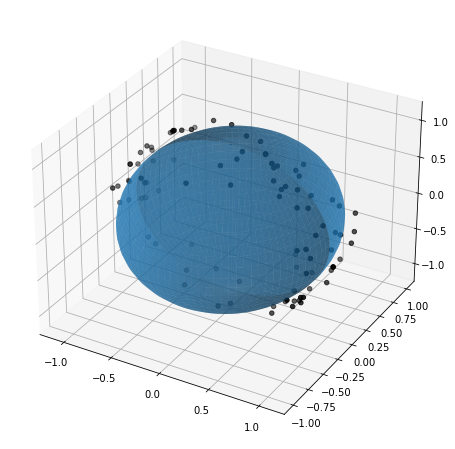

In [48]:
plot_angles(angles[:500])

In [ ]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg)))
#v0 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier)))

In [ ]:
#with mrcfile.new('../data/ground_truth_simulated.mrc', overwrite=True) as mrc:
#    mrc.set_data(vr.astype(np.float32))

## Optimization with respect to volume

### CG - applied to two halves of the data

In [ ]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 500

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

In [ ]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

In [ ]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

In [ ]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

In [ ]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

In [ ]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

In [ ]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [ ]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], x_grid[1])
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

#### Train/test stuff - something's wrong here

In [ ]:
res

In [ ]:
loss = []
for radius in res[1:]:
    mask = create_3d_mask(x_grid, (0,0,0),radius)
    mask_imgs = mask[0,:,:].reshape(1,-1)
    ll = loss_func_sum(vcg1 * mask, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:]*mask_imgs)   
    loss.append(ll)
    
loss = jnp.array(loss)

#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [ ]:
plt.plot(res[1:], loss)

### SGD

In [ ]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')